In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
def get_model_instance_segmentation(num_classes):
    # Load a pre-trained Faster R-CNN model
    model = fasterrcnn_resnet50_fpn(pretrained=True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one (adjusted for our dataset)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
num_classes = 91
model = get_model_instance_segmentation(num_classes)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

# Custom Dataset for a Single Image
class SingleImageDataset(Dataset):
    def __init__(self, img_path, transform=None, num_samples=100):
        self.img_path = img_path
        self.transform = transform
        self.num_samples = num_samples  # Augmented samples

    def __len__(self):
        return self.num_samples  # Artificially expand the dataset

    def __getitem__(self, idx):
        image = Image.open(self.img_path).convert("RGB")
        label = 0  # Example label for a single class
        if self.transform:
            image = self.transform(image)
        return image, label


# Define transformations for the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ResNet input
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
image_path = "/content/depositphotos_114726244-stock-photo-books-on-table-background.jpg"  # Replace with your image path
dataset = SingleImageDataset(image_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Load a pre-trained model (ResNet)
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1)  # Adjust output layer for 1 class

# Define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoch in range(5):  # Train for a few epochs
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

# Save the model
torch.save(model.state_dict(), "fine_tuned_model.pth")


Epoch 1, Loss: 0.0
Epoch 2, Loss: 0.0
Epoch 3, Loss: 0.0
Epoch 4, Loss: 0.0
Epoch 5, Loss: 0.0


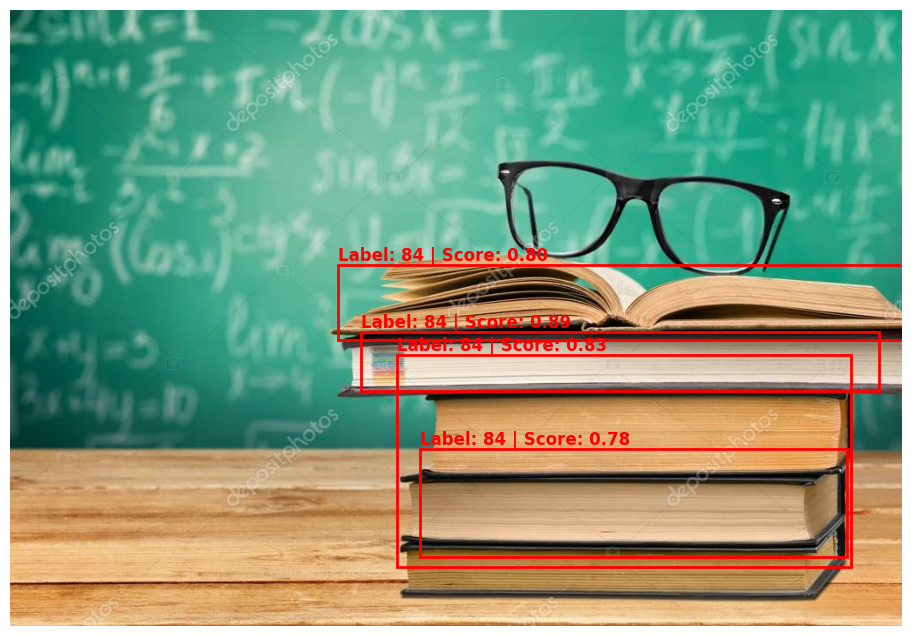

In [ ]:
import torch
import torchvision
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set to evaluation mode

# Load an image
image_path = "/content/depositphotos_114726244-stock-photo-books-on-table-background.jpg"   # Replace with your image path
image = Image.open(image_path).convert("RGB")

# Preprocess the image
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    predictions = model(input_image)

# Extract bounding boxes and scores
boxes = predictions[0]['boxes']  # Bounding boxes
scores = predictions[0]['scores']  # Confidence scores
labels = predictions[0]['labels']  # Predicted labels

# Filter predictions by a confidence threshold
threshold = 0.5
filtered_boxes = boxes[scores > threshold]
filtered_scores = scores[scores > threshold]
filtered_labels = labels[scores > threshold]

# Plot the image with bounding boxes
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image)

# Draw bounding boxes
for box, score, label in zip(filtered_boxes, filtered_scores, filtered_labels):
    x_min, y_min, x_max, y_max = box
    width = x_max - x_min
    height = y_max - y_min
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    # Add label and confidence score
    ax.text(x_min, y_min - 5, f"Label: {label.item()} | Score: {score:.2f}", color='red', fontsize=12, weight='bold')

plt.axis('off')
plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 153MB/s]


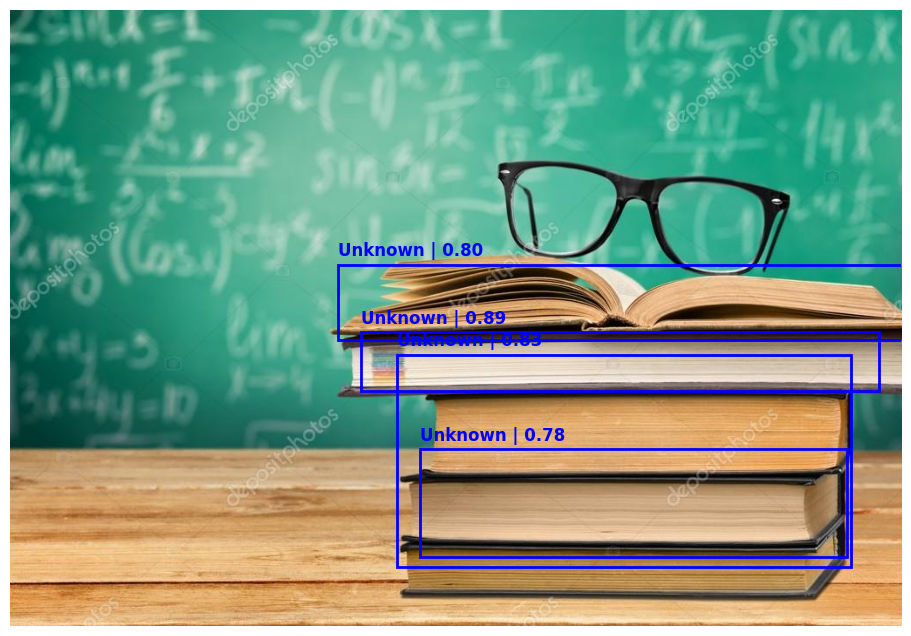

In [ ]:
import torch
import torchvision
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# COCO class names
COCO_INSTANCE_CATEGORY_NAMES = [
    "__background__", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse",
    "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase",
    "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard",
    "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch",
    "potted plant", "bed", "dining table", "toilet", "TV", "laptop", "mouse", "remote", "keyboard", "cell phone",
    "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear",
    "hair drier", "toothbrush"
]

# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set to evaluation mode

# Load an image
image_path = "/content/depositphotos_114726244-stock-photo-books-on-table-background.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")

# Preprocess the image
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    predictions = model(input_image)

# Extract predictions
boxes = predictions[0]['boxes']
scores = predictions[0]['scores']
labels = predictions[0]['labels']

# Filter predictions by confidence threshold
threshold = 0.5
filtered_boxes = boxes[scores > threshold]
filtered_scores = scores[scores > threshold]
filtered_labels = labels[scores > threshold]

# Plot the image with bounding boxes
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image)

# Draw bounding boxes and add class names
for box, score, label in zip(filtered_boxes, filtered_scores, filtered_labels):
    x_min, y_min, x_max, y_max = box
    width = x_max - x_min
    height = y_max - y_min

    # Check if the label is within range
    if 0 <= label.item() < len(COCO_INSTANCE_CATEGORY_NAMES):
        class_name = COCO_INSTANCE_CATEGORY_NAMES[label.item()]  # Get the class name
    else:
        class_name = "Unknown"  # Fallback for out-of-range labels

    # Draw bounding box
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='blue', facecolor='none')
    ax.add_patch(rect)

    # Add class name and confidence score
    ax.text(x_min, y_min - 10, f"{class_name} | {score:.2f}", color='blue', fontsize=12, weight='bold')

plt.axis('off')
plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 116MB/s]


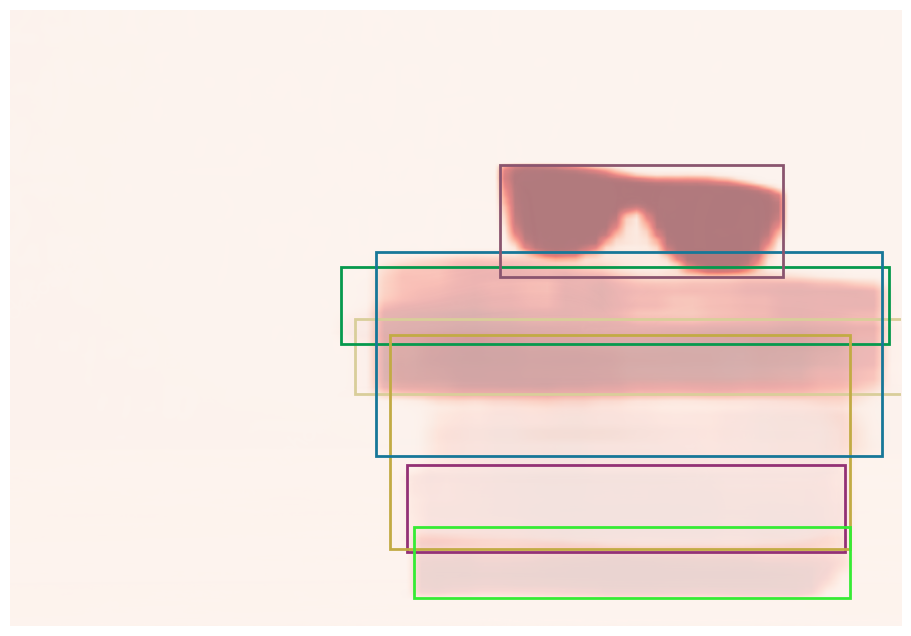

In [ ]:
import torch
import torchvision
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Load a pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set to evaluation mode

# Load an image
image_path = "/content/depositphotos_114726244-stock-photo-books-on-table-background.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")

# Preprocess the image
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    predictions = model(input_image)

# Extract bounding boxes, scores, labels, and masks
boxes = predictions[0]['boxes']
scores = predictions[0]['scores']
masks = predictions[0]['masks']

# Filter predictions by confidence threshold
threshold = 0.5
filtered_boxes = boxes[scores > threshold]
filtered_scores = scores[scores > threshold]
filtered_masks = masks[scores > threshold]

# Plot the image with bounding boxes and masks
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image)

# Draw bounding boxes and masks
for box, score, mask in zip(filtered_boxes, filtered_scores, filtered_masks):
    x_min, y_min, x_max, y_max = box
    width = x_max - x_min
    height = y_max - y_min

    # Generate a random color for the mask
    color = [random.random() for _ in range(3)]

    # Apply mask to the image
    mask = mask[0].mul(255).byte().cpu().numpy()  # Extract single channel
    ax.imshow(mask, cmap='Reds', alpha=0.5)  # Overlay mask

    # Draw bounding box
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

plt.axis('off')
plt.show()


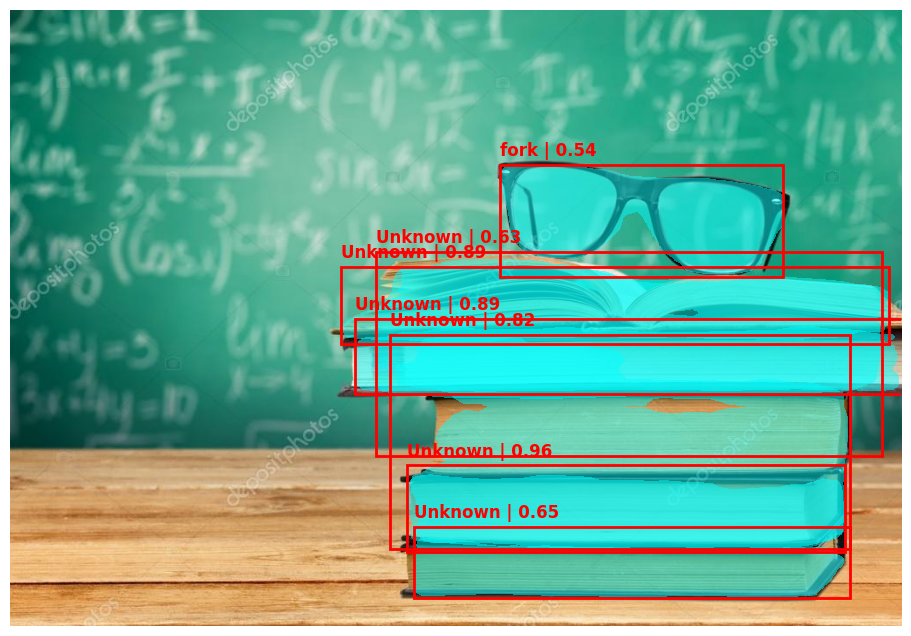

In [ ]:
import torch
import torchvision
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# COCO class names
COCO_INSTANCE_CATEGORY_NAMES = [
    "__background__", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse",
    "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase",
    "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard",
    "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch",
    "potted plant", "bed", "dining table", "toilet", "TV", "laptop", "mouse", "remote", "keyboard", "cell phone",
    "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear",
    "hair drier", "toothbrush"
]

# Load a pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set to evaluation mode

# Load an image
image_path = "/content/depositphotos_114726244-stock-photo-books-on-table-background.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")

# Preprocess the image
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    predictions = model(input_image)

# Extract predictions
boxes = predictions[0]['boxes']
scores = predictions[0]['scores']
labels = predictions[0]['labels']
masks = predictions[0]['masks']

# Filter predictions by confidence threshold
threshold = 0.5
filtered_boxes = boxes[scores > threshold]
filtered_scores = scores[scores > threshold]
filtered_labels = labels[scores > threshold]
filtered_masks = masks[scores > threshold]

# Convert masks to binary
filtered_masks = (filtered_masks > 0.5).squeeze(1).cpu().numpy()

# Plot the image with bounding boxes and masks
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image)

# Draw bounding boxes and add class names
for box, score, label, mask in zip(filtered_boxes, filtered_scores, filtered_labels, filtered_masks):
    x_min, y_min, x_max, y_max = box
    width = x_max - x_min
    height = y_max - y_min

    # Check if the label is within range
    if 0 <= label.item() < len(COCO_INSTANCE_CATEGORY_NAMES):
        class_name = COCO_INSTANCE_CATEGORY_NAMES[label.item()]  # Get the class name
    else:
        class_name = "Unknown"  # Fallback for out-of-range labels

    # Draw bounding box
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    # Add class name and confidence score
    ax.text(x_min, y_min - 10, f"{class_name} | {score:.2f}", color='red', fontsize=12, weight='bold')

    # Overlay mask
    mask = np.ma.masked_where(mask == 0, mask)
    ax.imshow(mask, alpha=0.5, cmap="cool", interpolation="none")

plt.axis('off')
plt.show()


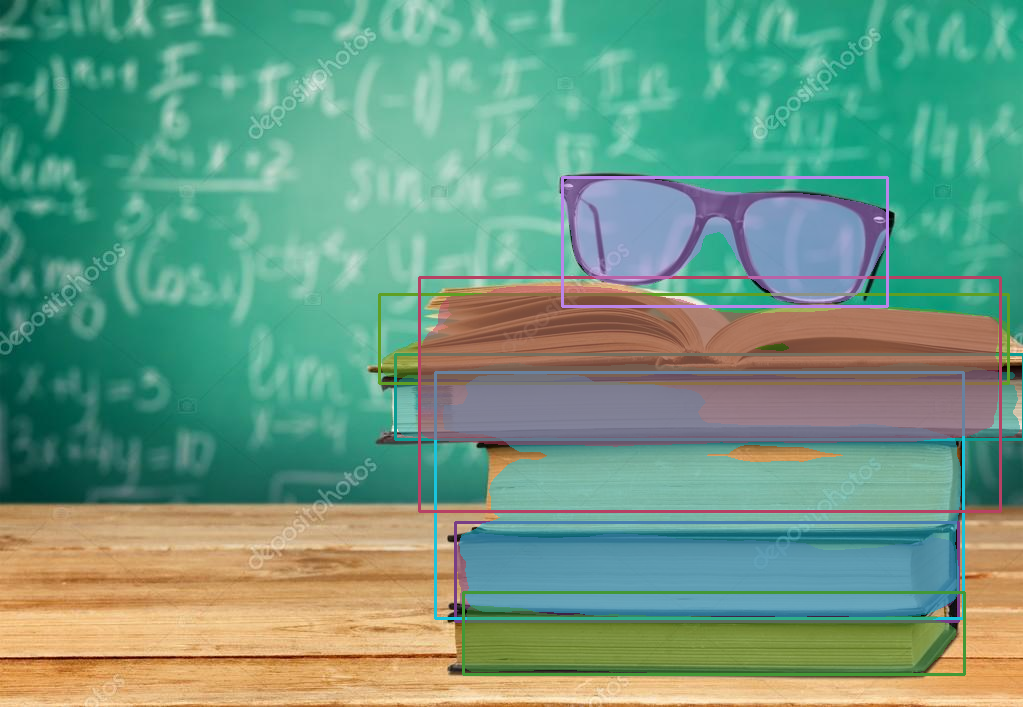

In [ ]:
import cv2
import numpy as np
import torch
import torchvision
from torchvision.transforms import functional as F
from PIL import Image
from google.colab.patches import cv2_imshow  # For displaying images in Colab

# Load a pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set to evaluation mode

# Load an image
image_path = "/content/depositphotos_114726244-stock-photo-books-on-table-background.jpg"  # Replace with your image path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
original_image = image.copy()

# Preprocess the image
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
input_image = transform(Image.fromarray(image)).unsqueeze(0)  # Convert to PIL Image, then Tensor

# Perform inference
with torch.no_grad():
    predictions = model(input_image)

# Extract bounding boxes, scores, labels, and masks
boxes = predictions[0]['boxes']
scores = predictions[0]['scores']
masks = predictions[0]['masks']

# Filter predictions by confidence threshold
threshold = 0.5
filtered_boxes = boxes[scores > threshold]
filtered_scores = scores[scores > threshold]
filtered_masks = masks[scores > threshold]

# Convert the filtered masks to binary
binary_masks = (filtered_masks > 0.5).squeeze(1).cpu().numpy()

# Draw bounding boxes and masks
for i in range(len(filtered_boxes)):
    # Get bounding box coordinates
    box = filtered_boxes[i].cpu().numpy()
    x_min, y_min, x_max, y_max = map(int, box)

    # Generate random color for the mask
    color = [int(c) for c in np.random.randint(0, 255, size=3)]

    # Apply the mask to the image
    mask = binary_masks[i]
    mask = mask.astype(np.uint8)
    image[mask > 0] = image[mask > 0] * 0.5 + np.array(color) * 0.5

    # Draw the bounding box
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)

# Convert back to BGR for OpenCV display
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# Display the result using cv2_imshow
cv2_imshow(image)
